# Altitude: An Observational Study ⛰️

Hypothesis: Long range field goals have a greater change of conversion at altitude than sea-level.

In [16]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import mysql.connector
import itertools
import dtale
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from util.data import clean, get_data

## Load & Clean

In [4]:
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, 'g.seas<=2019', xp=False, base='raw_6_cat')
df = clean(df, dropna=False)
df

,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
2166,AD-0800,1,38,2000,17,73,BUF,Ralph Wilson Stadium,TEN,0,...,1,10,1,0,0,1,0,1,0.764708,765
2185,AD-0800,1,27,2000,17,73,BUF,Ralph Wilson Stadium,TEN,0,...,1,10,1,0,0,1,0,1,0.807721,766
4565,AD-0800,1,36,2000,17,80,TEN,Adelphia Coliseum,TEN,0,...,1,13,0,0,1,0,0,5,NaN,767
8564,AD-0800,1,24,2000,17,61,PIT,Three Rivers Stadium,TEN,0,...,0,16,1,0,0,1,1,1,0.842837,768
8628,AD-0800,1,40,2000,17,61,PIT,Three Rivers Stadium,TEN,0,...,0,16,1,0,0,1,1,1,0.871516,769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862982,ZG-0050,1,30,2019,3,66,ARI,State Farm Stadium,ARI,0,...,0,0,0,0,0,0,0,1,0.826709,62
865338,ZG-0050,1,21,2019,3,66,ARI,State Farm Stadium,ARI,0,...,0,11,0,0,0,0,0,2,0.858217,63
868268,ZG-0050,1,22,2019,3,43,SEA,CenturyLink Field,ARI,0,...,1,7,1,0,0,1,0,1,1.000000,64


## Explore

There seems to be a slight up-tick for long range kicks (+45 yards), but the sample size is quite small, as indicated by the confidence bands.

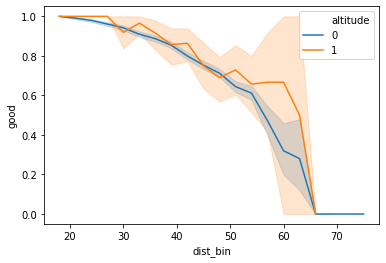

In [5]:
df_ = df.copy()
df_['dist_bin'] = 3*round(df_['dist']/3)
sns.lineplot(x='dist_bin', y='good', hue='altitude', data=df_)

## Pair

We filter for away kicks at greater than 45 yards. We choose away kicks because only Denver home games are at altitude, so need to avoid biasing for Broncos kicker.

In [82]:
df_longaway = df[(df['away_game']==1) & (df['dist']>=45)].drop(['fkicker', 'home_team', 'stadium', 'team', 'XP', 'away_game'], axis=1)
df_longaway['form'] = df_longaway['form'].fillna(method='bfill')
print(df_longaway['altitude'].value_counts())
df_longaway

0    2415
1      99
Name: altitude, dtype: int64


,good,dist,year,seasons,temperature,age,altitude,humid,wind,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,
20774,1,46,2000,17,54,38,0,0,9,0,0,0,0,1,0.710344,779
32219,1,50,2000,17,30,38,0,0,7,0,1,1,0,6,0.961555,795
479437,0,63,2011,1,61,24,0,0,0,0,0,1,0,1,0.605990,2
513552,1,51,2011,1,70,24,0,0,0,0,0,1,0,2,0.730446,24
519075,0,45,2012,2,68,25,0,0,9,0,0,0,0,2,1.000000,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827414,1,55,2018,2,45,23,0,1,5,0,0,1,0,6,1.000000,32
844674,1,47,2019,3,56,24,0,1,3,0,0,1,1,1,0.813096,52
846996,1,50,2019,3,70,24,0,0,0,0,0,1,0,1,0.771461,56


We find paired kicks for altitude and sea-level with replacement using mahalanobis distance.

In [97]:
from util.matching import match

df_longaway['altitude'] = df_longaway['altitude'].astype(bool)
matches = match(df_longaway.drop('good', axis=1), t='altitude', distance='mahalanobis', method='with_replacement', caliper=2)
unique_treatments = set(map(lambda x: x['match'], matches.values())) # potentially repeated treatment samples
unique_controls = set(matches.keys())
match_ids = unique_controls.union(unique_treatments)
overlap = unique_controls.intersection(unique_treatments)
print(len(unique_treatments), 'altitude samples.', len(unique_controls), 'sea-level samples.', len(overlap), 'overlapping.')
df_matched = df.loc[match_ids, :]
df_matched

70 altitude samples. 378 sea-level samples. 0 overlapping.


,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
151553,DA-0300,0,47,2003,6,39,GB,Lambeau Field,PHI,0,...,1,8,1,0,0,0,1,1,0.922712,257
525313,JH-0900,1,53,2012,21,68,TEN,LP Field,DET,0,...,0,5,1,0,0,0,0,1,0.793538,729
226305,RB-2200,1,52,2005,1,70,HOU,Reliant Stadium,TEN,0,...,0,0,1,0,0,0,0,1,0.972335,8
306184,DR-0600,1,45,2007,3,70,CHI,Soldier Field,KC\r,0,...,0,11,1,0,0,0,0,1,0.802812,34
575498,GG-0100,1,51,2013,5,82,ARI,University of Phoenix Stadium,CAR,0,...,0,0,1,0,0,0,0,1,0.852681,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263153,LT-1100,1,45,2006,3,61,DEN,Invesco Field at Mile High,KC\r,0,...,0,7,1,0,0,0,0,1,0.866740,57
492530,JH-0900,1,50,2011,20,56,DEN,Sports Authority Field at Mile High,DET,0,...,0,5,1,0,0,0,0,1,0.851279,710
525300,JH-0900,1,47,2012,21,68,TEN,LP Field,DET,0,...,0,5,1,0,0,0,0,1,0.747658,728


In [98]:
df_alt = df_matched.loc[df_matched['altitude']==1, :]
df_sea = df_matched.loc[df_matched['altitude']==0, :]
print(len(df_alt), 'at altidude.', len(df_sea), 'at sea-level.')

70 at altidude. 378 at sea-level.


## Model

We work within a Bayesian framework, setting a prior distribution on the true population proportion and update the prior after our observations. The Beta-Binomial conjugacy makes this process relatively pain-free. Our prior mean is the sample population proportion (all kicks).

In [99]:
from scipy.stats import beta
p_hat = df[df['dist']>=45]['good'].mean()
# beta_ = 2
# alpha_ = int(round(p_hat*beta_/(1-p_hat)))
alpha_ = 12
beta_ = int(round(alpha_*(1-p_hat)/p_hat))
print(f'alpha: {alpha_}, beta: {beta_}')

alpha: 12, beta: 6


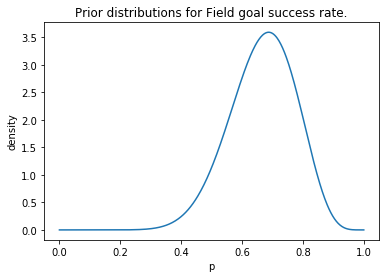

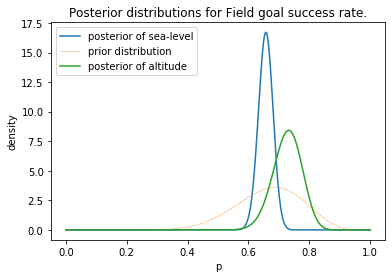

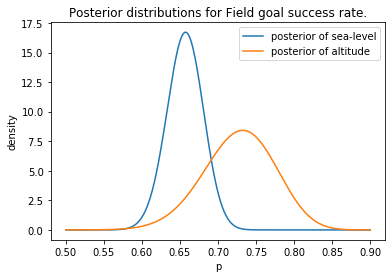

In [100]:
from util.bayes import BetaBinomial

control = BetaBinomial(alpha_, beta_, 'sea-level')
treatment = BetaBinomial(alpha_, beta_, 'altitude')
control.plot_prior(show=True)
plt.cla()

control.observe(df_sea['good'])
treatment.observe(df_alt['good'])

control.plot_posterior(prior=False)
treatment.plot_posterior(show=True, prior=True)

# zoom in
x = np.linspace(0.5,0.9,500)
control.plot_posterior(x, prior=False, show=False)
treatment.plot_posterior(x, prior=False, show=True)

samples = 20000
samples_posterior_sea = control.sample(samples)
samples_posterior_alt = treatment.sample(samples)

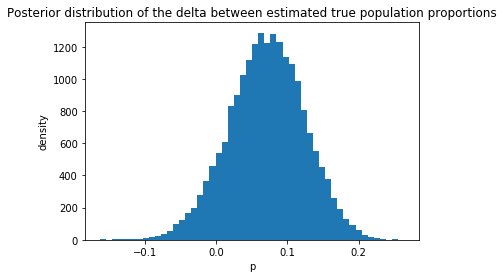

90% likely that altitude has a greater true population proportion of converted field goals.
0.07 is the median difference, with 50% credible interval of (0.0,0.14).


In [101]:
posterior_diff = samples_posterior_alt - samples_posterior_sea

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions')
plt.show()
gt = int((samples_posterior_alt>samples_posterior_sea).mean()*100)
print(f'{gt}% likely that altitude has a greater true population proportion of converted field goals.')

from scipy.stats import bayes_mvs
alpha = 0.5
center, _, _ = bayes_mvs(posterior_diff, alpha=alpha)
print(f'{round(center.statistic,2)} is the median difference, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

We are sometimes interested in relative increase. For instance, the difference between 0.6 and 0.7 is relatively larger than the difference between 0.7 and 0.8.
We calculate relative increase of our treatment (altitude) over control (sea-level) using our posterior distributions.

54 % likely relative lift is greater than 10%.
0.11 is the median relative lift, with 50% credible interval of (0.0,0.22).


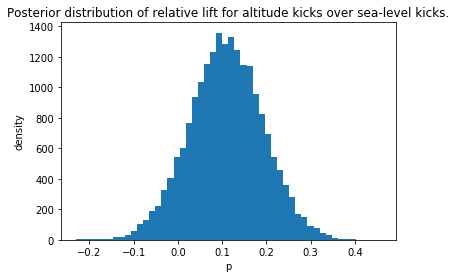

In [102]:
posterior_relative = (samples_posterior_alt-samples_posterior_sea)/samples_posterior_sea
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of relative lift for altitude kicks over sea-level kicks.')
print(int((posterior_relative>0.1).mean()*100), r'% likely relative lift is greater than 10%.')

alpha = 0.5
center, _, _ = bayes_mvs(posterior_relative, alpha=alpha)
print(f'{round(center.statistic,2)} is the median relative lift, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')